In [5]:
#this will examine the price fluctuations of a few specific products... 
#and then look to generalise the price movements for all products
# final step will be to combine price and products to see the correlation

In [6]:
#load the data, add a few key variables, reduce to a specific product
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import pixiedust as pix
dateCols = ['date']
train2=pd.read_csv("/home/cdsw/train_plus_not_imputted.csv",parse_dates=dateCols)
train2["TotalRevenue"]=train2.item_cnt_day*train2.item_price
train2["Month"]=train2.date.dt.month
train2["Year"]=train2.date.dt.year
train2['YM'] = train2['Year']*100+train2["Month"]

#create an average per month - see how it changes
sales_per_item_PM= train2.groupby(['item_id','YM'])['item_cnt_day',"TotalRevenue" ].sum().reset_index()
sales_per_item_PM["AvPrice"]=sales_per_item_PM.TotalRevenue/sales_per_item_PM.item_cnt_day

#for later so can look at volume change over time against the product
sales_perM= sales_per_item_PM.pivot_table(index=["item_id"],columns="YM",values="item_cnt_day", fill_value=0).reset_index() 

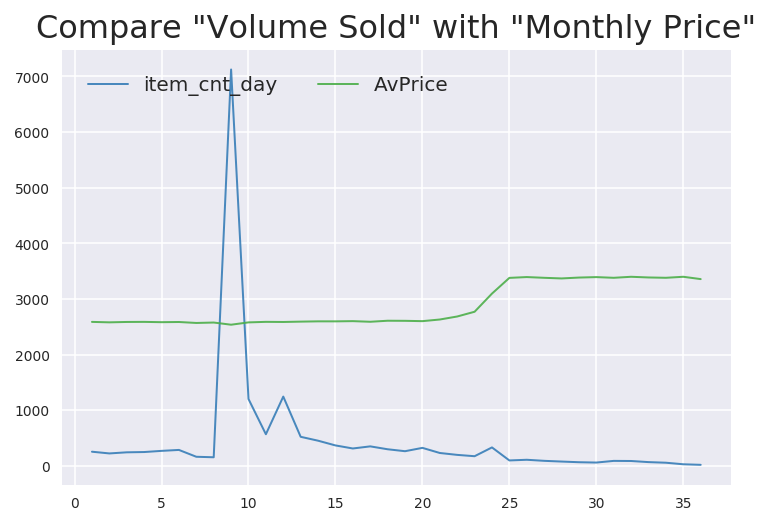

In [7]:
it_3732=sales_per_item_PM[sales_per_item_PM.item_id==3732].drop(["item_id","TotalRevenue"],axis=1)
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in it_3732.drop('YM', axis=1):
    num+=1
    plt.plot(range(1,37), it_3732[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
    # Add legend
    plt.legend(loc=2, ncol=2)
plt.title('Compare "Volume Sold" with "Monthly Price"', fontsize=16)
plt.show()



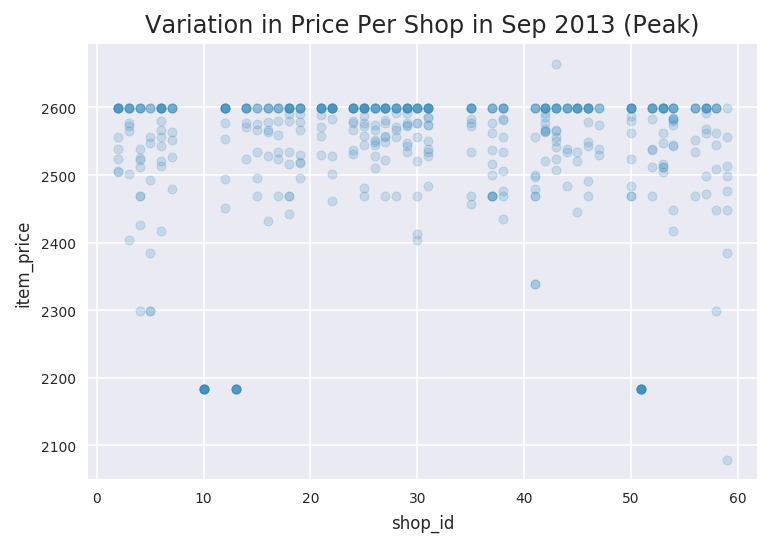

In [8]:
#look at the price for one product per shop in 201309 as that's the peak
scat=train2[(train2.item_id==3732) & (train2.YM==201309)]
scat.plot(kind="scatter",x="shop_id",y="item_price", alpha=0.2)
plt.title('Variation in Price Per Shop in Sep 2013 (Peak)', fontsize=12)


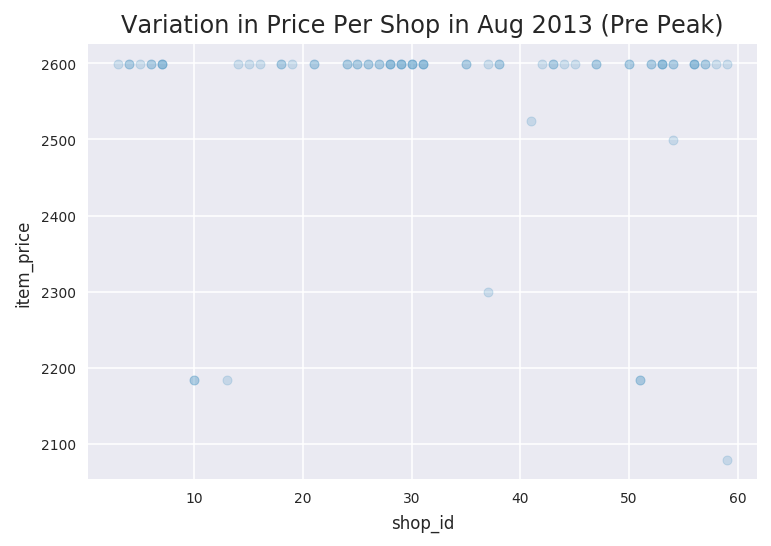

In [9]:
#how was the variation before
scat_pre=train2[(train2.item_id==3732) & (train2.YM==201308)]
scat_pre.plot(kind="scatter",x="shop_id",y="item_price", alpha=0.2)
plt.title('Variation in Price Per Shop in Aug 2013 (Pre Peak)', fontsize=12)

In [10]:
#this shows that there was almost no variation in the price in the pre spike month and then quite a lot of variation when spike happened
#how much was sold in 201309 where price matched the median in 201308
med=train2.item_price[(train2.YM==201308) &(train2.item_id==3732)].median()
print("Number sold in 201309 where price was same as 2018:",
      train2.item_cnt_day[(train2.item_price== med ) & (train2.item_id==3732)& (train2.YM==201309)].sum())

print("Number sold in 201308:", train2.item_cnt_day[(train2.YM==201308) &(train2.item_id==3732)].sum())

Number sold in 201309 where price was same as 2018: 1067.0
Number sold in 201308: 154.0


In [11]:
#so this says that actually the variation in month drives the sales... even where its the same price as last month

#how do some of the other prior months look - consistency makes theory true? or looks inconclusive?

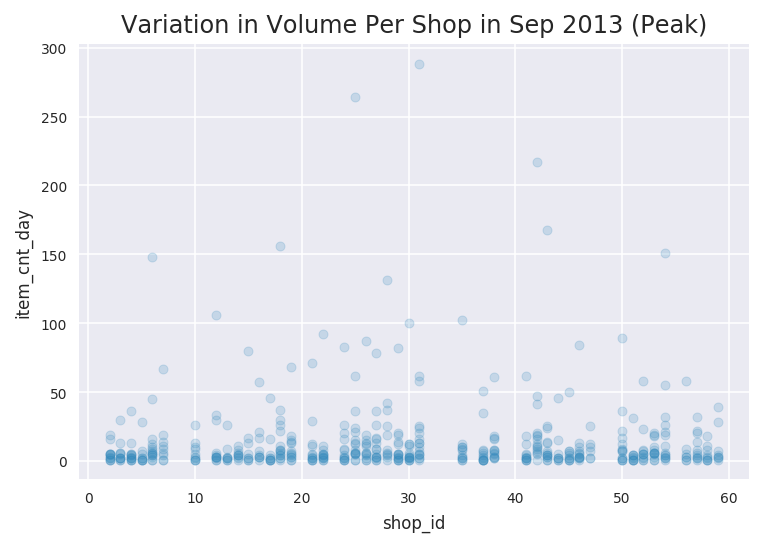

In [12]:
#this needs to be changed so get better understanding of the volumes - maybe grouped version
scat.plot(kind="scatter", x="shop_id",y="item_cnt_day", alpha=0.2)
plt.title('Variation in Volume Per Shop in Sep 2013 (Peak)', fontsize=12)


In [13]:
#wanted to see the volume really changing but hard to see

In [14]:
def scat_months2(df,prod,over_title):
    """Print scatter for all months as sub plots of any given product"""
    uniq=sorted(set(train2["YM"]))
    fig, axes = plt.subplots(12,3,figsize=(10, 30), sharex=True, sharey=True)
    for i,period in enumerate(uniq):
        df[(df["YM"]==period) & (df["item_id"]==prod)].plot(x='shop_id',
                y='item_price',
                kind='scatter',
                alpha=0.2,
                label=period,
                ax=axes.flatten()[i])
    plt.title(over_title, fontsize=12)
    fig.tight_layout()
    
    plt.show()

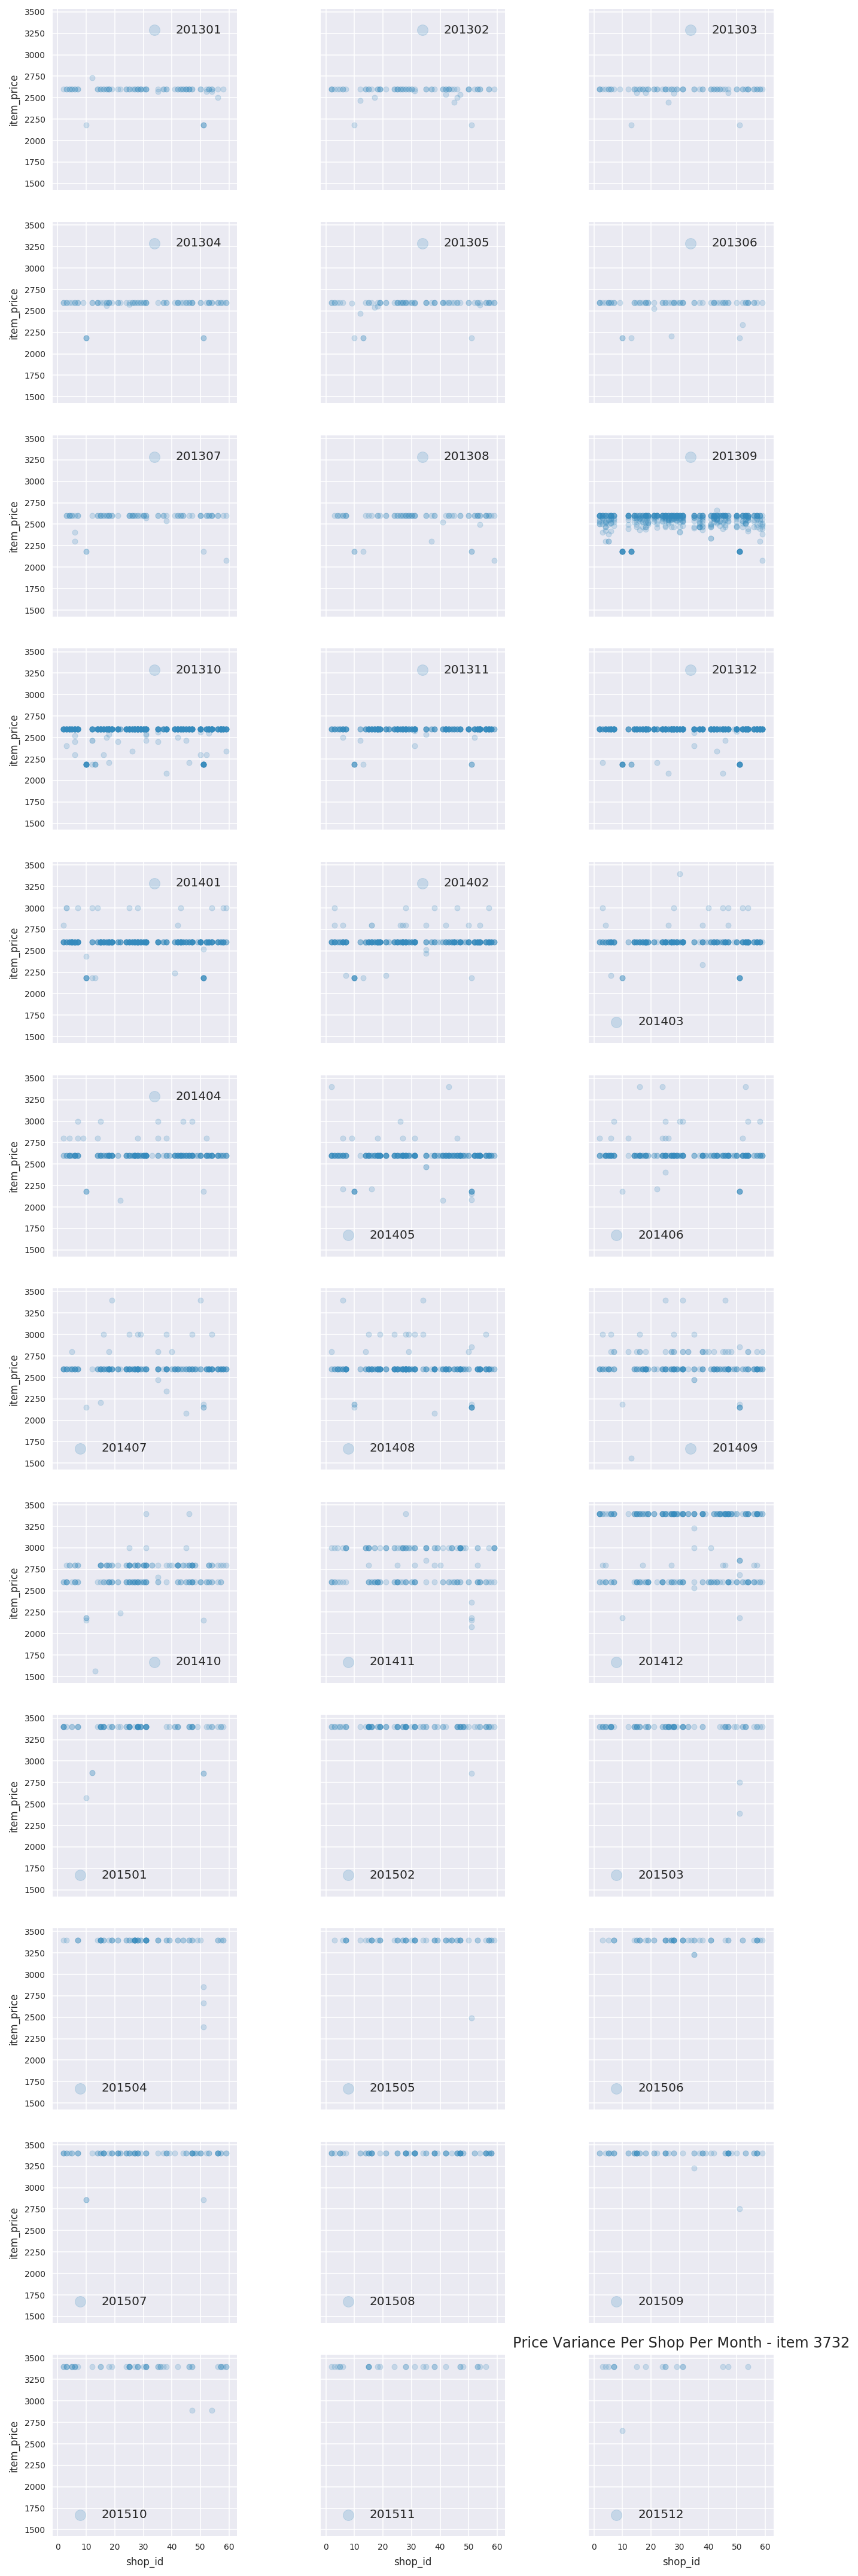

In [15]:
scat_months2(train2,3732,"Price Variance Per Shop Per Month - item 3732")

In [16]:
#review a view of these - could there be a variance link which drives volume?  Are there behaviours for shops where drop price 
#& generates volume in following days?

(2000, 2750)

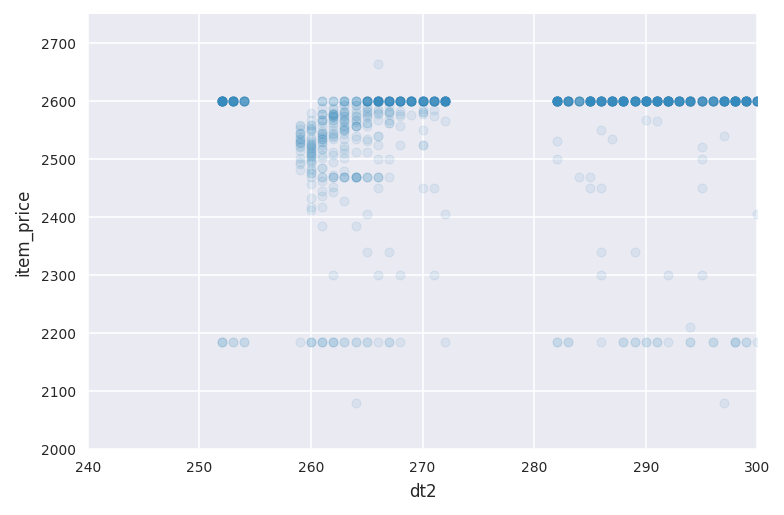

In [17]:
# scatter plot by day the price - try to see how develops against sales volumes
train2["dt"]=train2["date"].astype(np.int64)/86400000000000
train2["dt2"]=train2.dt-train2.dt.min()

train2[train2.item_id==3732].plot(kind="scatter",x="dt2",y="item_price",alpha=0.1)
plt.axes().set_xticks([240,250,260,270,280,290,300])
plt.axes().set_xlim([240,300])
plt.axes().set_ylim([2000,2750])

(240, 300)

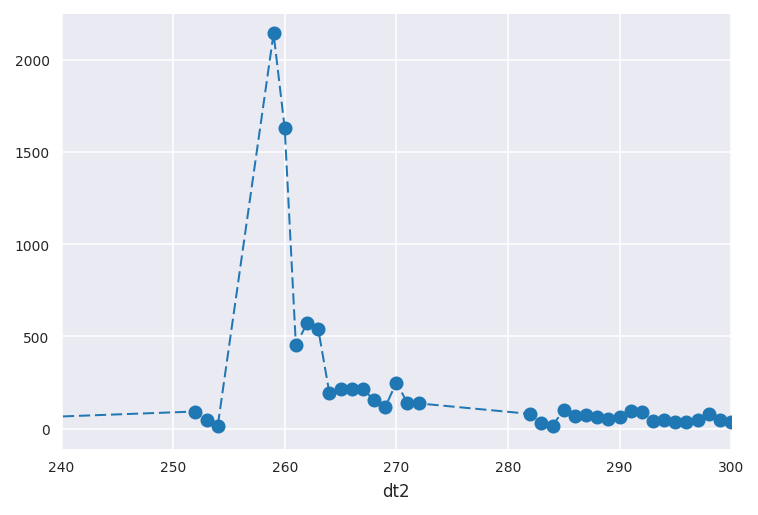

In [18]:
#need to group this by day and then can plot
train2[train2.item_id==3732].groupby(["dt2"])["item_cnt_day"].sum().plot(kind="line",x="dt2",y="item_cnt_day",linestyle='--', marker='o')
#plt.axes().set_xticks([0,100,200,250,300,350,400,600,800,1000])
plt.axes().set_xticks([240,250,260,270,280,290,300])
plt.axes().set_xlim([240,300])


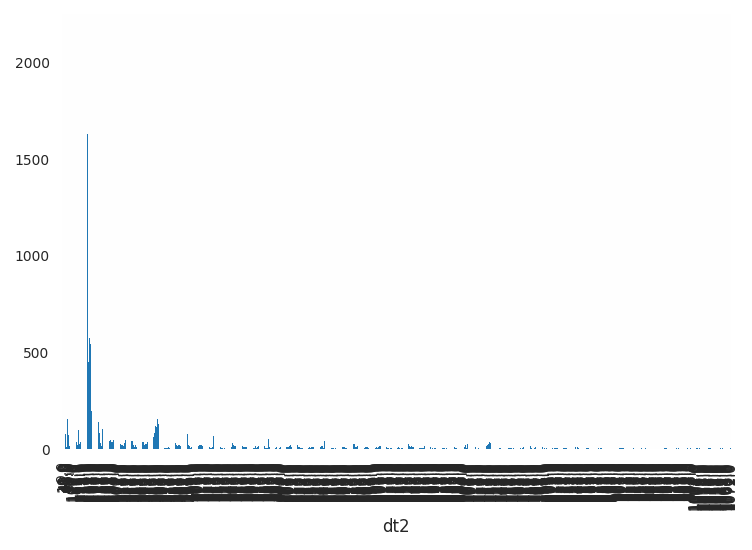

In [19]:
#so the spike happens the same day as a change in price - potentially advertised OK..
#but the gap in the sales days is weird... it is not consistent over time... was it out of stock and then changed?
#need to check some others...look at chart per day over the entire time - bar so can see where zero
train2[train2.item_id==3732].groupby(["dt2"])["item_cnt_day"].sum().plot(kind="bar",x="dt2",y="item_cnt_day")

In [34]:
#constant gaps - but hard to read - let's pivot the data to see if I can group and see where have issues
table_3732 = pd.pivot_table(train2[train2.item_id==3732], values='item_cnt_day', index=['YM', 'date'], aggfunc=np.sum)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(table_3732)


                   item_cnt_day
YM     date                    
201301 2013-01-10         178.0
       2013-01-11          51.0
       2013-01-12          25.0
201302 2013-02-10         133.0
       2013-02-11          78.0
       2013-02-12          12.0
201303 2013-03-10         157.0
       2013-03-11          73.0
       2013-03-12          13.0
201304 2013-04-10         169.0
       2013-04-11          57.0
       2013-04-12          22.0
201305 2013-05-10         230.0
       2013-05-11          28.0
       2013-05-12          11.0
201306 2013-06-10         232.0
       2013-06-11          34.0
       2013-06-12          20.0
201307 2013-07-10          98.0
       2013-07-11          28.0
       2013-07-12          37.0
201308 2013-08-10          98.0
       2013-08-11          28.0
       2013-08-12          28.0
201309 2013-09-10          93.0
       2013-09-11          45.0
       2013-09-12          16.0
       2013-09-17        2144.0
       2013-09-18        1629.0
       2

In [33]:
#appears to be available for 6 months in limited quantities... and then picks up... 
#potential features engineering, might suggest need a variable of when last not sold and length of time prior to that
    #will be a challenge with the very low volumes
    
#for prod 17717 - look at pivot - when sold - then maybe price variation on data
table_17717= pd.pivot_table(train2[train2.item_id==17717], values="item_cnt_day", index=["YM","date"], aggfunc=(np.sum))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(table_17717)

                   item_cnt_day
YM     date                    
201301 2013-01-01           1.0
       2013-01-02           2.0
       2013-01-03           5.0
       2013-01-04           3.0
       2013-01-05          13.0
       2013-01-06           2.0
       2013-01-07           2.0
       2013-01-08           2.0
       2013-01-09           3.0
       2013-01-10           2.0
       2013-01-11           1.0
       2013-01-12           1.0
       2013-01-13           1.0
       2013-01-14           1.0
       2013-01-16           3.0
       2013-01-17           2.0
       2013-01-18           1.0
       2013-01-19           3.0
       2013-01-20           3.0
       2013-01-21           2.0
       2013-01-23           7.0
       2013-01-24           7.0
       2013-01-25           9.0
       2013-01-26          13.0
       2013-01-27          18.0
       2013-01-28           6.0
       2013-01-29          11.0
       2013-01-30          10.0
       2013-01-31           1.0
201302 2

In [35]:
print(len(table_3732))
print(len(table_17717))
#can't really use this as the splitter....

730
962


In [20]:
#create a box plot - with the volume for a weight?  Show the variation - 
#also per month, value that is not the median for that month